In [5]:
# probabilitic modeling numpyro
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal
import numpyro.optim as optim
# inference
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive 

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

# ploting and stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import arviz

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas

In [6]:
df = pandas.read_parquet('../sample_data/num_of_trips.parquet')
df = (
    # limiting data to only two districts
    df[df['PU_Borough'].isin(['Manhattan', 'Queens', 'Brooklyn'])]
    # recasting datatype (seaborn still shows old districts using pd.cat.categories)
    .astype({'PU_Borough': 'object'}).astype({'PU_Borough': 'category'})
    .reset_index(drop=True)
    # actually I want to do poisson regression to I will revert the transformation in this data
    .assign(num_of_trips=lambda x: np.exp(x['num_of_trips']) -1)
)
df.head()

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
0,2023-01-01 00:00:00,Brooklyn,37.0,0,6,0.000000,1.000000,-0.781831,0.62349
1,2023-01-01 00:00:00,Manhattan,4444.0,0,6,0.000000,1.000000,-0.781831,0.62349
2,2023-01-01 00:00:00,Queens,262.0,0,6,0.000000,1.000000,-0.781831,0.62349
3,2023-01-01 01:00:00,Brooklyn,123.0,1,6,0.258819,0.965926,-0.781831,0.62349
4,2023-01-01 01:00:00,Manhattan,4722.0,1,6,0.258819,0.965926,-0.781831,0.62349


In [7]:
# split condition
condition = df['tpep_pickup_datetime'] < '2023-01-22'
df_train, df_test = df[condition], df[~condition]

df_train

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
0,2023-01-01 00:00:00,Brooklyn,37.0,0,6,0.000000,1.000000,-0.781831,0.623490
1,2023-01-01 00:00:00,Manhattan,4444.0,0,6,0.000000,1.000000,-0.781831,0.623490
2,2023-01-01 00:00:00,Queens,262.0,0,6,0.000000,1.000000,-0.781831,0.623490
3,2023-01-01 01:00:00,Brooklyn,123.0,1,6,0.258819,0.965926,-0.781831,0.623490
4,2023-01-01 01:00:00,Manhattan,4722.0,1,6,0.258819,0.965926,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...
1507,2023-01-21 22:00:00,Manhattan,5621.0,22,5,-0.500000,0.866025,-0.974928,-0.222521
1508,2023-01-21 22:00:00,Queens,430.0,22,5,-0.500000,0.866025,-0.974928,-0.222521
1509,2023-01-21 23:00:00,Brooklyn,64.0,23,5,-0.258819,0.965926,-0.974928,-0.222521
1510,2023-01-21 23:00:00,Manhattan,6057.0,23,5,-0.258819,0.965926,-0.974928,-0.222521


In [8]:
transformers = ColumnTransformer([
    # onehot encoding borough
    ('encode_borough', OrdinalEncoder(dtype=np.int8), ['PU_Borough', 'hour', 'day_of_week']),
    # normalizing target variable to 0 to 1 scale
    # ('normalize_target', MinMaxScaler(), ['num_of_trips']),
    ('pass', 'passthrough', ['num_of_trips']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

data_processing_pipe = Pipeline([
    ('transformers', transformers),
])

df_train_processed = data_processing_pipe.fit_transform(df_train)
X_features = [i for i in df_train_processed.columns if i != 'num_of_trips']
target = ['num_of_trips']
# X_train, y_train = df_train_processed[X_features], df_train_processed[target]
df_test_processed = data_processing_pipe.transform(df_test)
# X_test, y_test = df_test_processed[X_features], df_test_processed[target]

# Baysian models

## 1. Average for each boroghs

Abviously this is not the best model, but I want to step by step document progression in building model describing the process. 

In general we can describe the number of trips as a process that takes values from $[0,\infty]$, ie each observation is a sample from a Poisson distributuion.
Not that each boroght has a different expected number of trips in each case so I want to have $N$ different models for each city that use the general pattern of seasonality during the day and week

Starting out simple:

$$
numtrips \sim Poisson(\lambda)\\
\lambda = \beta_{[borough]} \\
\beta_{[borough]} \sim Normal(2, 1)\\
$$

In [37]:
def model1(N_boroughs, borough=None, hour=None, day_of_week=None, num_of_trips=None):
    # additional constraint that the effect of city will always be a positive parameter
    borough_mean = numpyro.param("alpha_q", 2, constraint=dist.constraints.positive)
    beta_borough = numpyro.sample('beta_borough', dist.Normal(borough_mean, 1).expand([N_boroughs]))

    # target
    lam = numpyro.deterministic('lam', jnp.exp(
        beta_borough[borough]
    ))
    numpyro.sample('num_of_trips', dist.Poisson(lam), obs=num_of_trips)


def data_model1(df):
    dlist = dict(
        N_boroughs=len(df['PU_Borough'].unique()),
        borough=df['PU_Borough'].values,
        hour=df['hour'].values,
        day_of_week=df['day_of_week'].values,
    )
    target = dict(num_of_trips=df['num_of_trips'].values)
    return dlist, target

dlist, target = data_model1(df_train_processed)
mcmc1 = MCMC(NUTS(model1), num_chains=4, num_warmup=250, num_samples=250)
mcmc1.run(random.PRNGKey(0), **dlist, **target)
arviz.summary(mcmc1, var_names=['~lam'], hdi_prob=.89)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_borough[0],2.641,0.012,2.621,2.659,0.001,0.001,242.0,353.0,1.03
beta_borough[1],8.133,0.001,8.132,8.134,0.000,0.000,1202.0,805.0,1.00
beta_borough[2],5.895,0.002,5.891,5.899,0.000,0.000,539.0,606.0,1.01


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

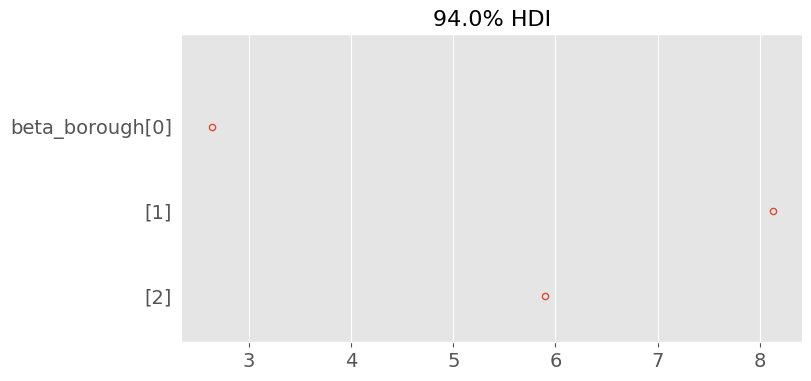

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
arviz.plot_forest(mcmc1, var_names=['beta_borough'], combined=True, ax=ax)

So the beta_borough in case of this model is exactly the mean rate contribution to the model. We can calculate the contribution of parameters following glm equation

$$
\log(\lambda) = \beta_{[borough]}\\
\lambda = exp(\beta_{[borough]})
$$

ie the average for each borough is

In [17]:
np.exp([2.641, 8.133, 5.895])

array([  14.02722382, 3404.99925572,  363.2168359 ])

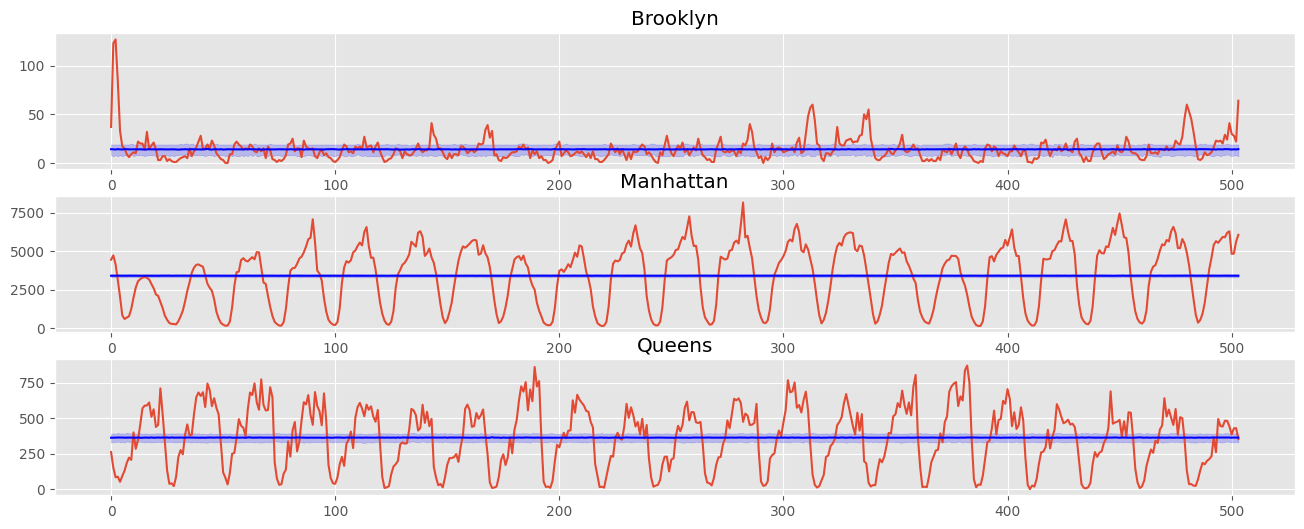

In [106]:
def post_pred_df(df, samples):
    df_predictions = df.copy()
    mean = samples.mean(0)
    hdi = hpdi(samples, 0.89, 0)
    df_predictions['pred'], df_predictions['hdi_low'], df_predictions['hdi_high'] = mean, hdi[0, :], hdi[1, :]
    
    return df_predictions

def plot_posterior(df):
    fig, ax = plt.subplots(3, 1, figsize=(16, 6))

    for borough in df['PU_Borough'].unique():
        city_df = df[df['PU_Borough'] == borough]
        t = np.arange(0, len(city_df))
        ax[borough].plot(t, city_df['num_of_trips'])
        ax[borough].plot(t, city_df['pred'], 'blue')
        ax[borough].fill_between(t, y1=city_df['hdi_low'], y2=city_df['hdi_high'], alpha=.2, color='blue')
        ax[borough].set_title(transformers.named_transformers_['encode_borough'].categories_[0][borough])

predictive = Predictive(model1, mcmc1.get_samples())
predictive_samples = predictive(random.PRNGKey(1), **dlist)['num_of_trips'] #(samples, observation)
df_predictions = post_pred_df(df_train_processed, predictive_samples)
plot_posterior(df_predictions)

So obviously this type of model is not able to predict accurately, but we can build on from there, next adding the effect of hours

## Borough + hour model

So the average is changing significantly around different boroughs, but the trend during the day seems to be the same. To test this I will consider the following model

$$
numtrips \sim Poisson(\lambda)\\
\lambda = \beta_{[borough]} \\
\beta_{[borough, hour]} \sim Normal(2, 1)\\
$$

In [44]:
def model2(N_boroughs, borough=None, hour=None, day_of_week=None, num_of_trips=None):
    # additional constraint that the effect of city will always be a positive parameter
    borough_mean = numpyro.param("alpha_q", 2, constraint=dist.constraints.positive)
    beta_borough = numpyro.sample('beta_borough', dist.Normal(borough_mean, 1).expand([N_boroughs, 24]))

    # target
    lam = numpyro.deterministic('lam', jnp.exp(
        beta_borough[borough, hour]
    ))
    numpyro.sample('num_of_trips', dist.Poisson(lam), obs=num_of_trips)


dlist, target = data_model1(df_train_processed)
mcmc2 = MCMC(NUTS(model2), num_chains=4, num_warmup=500, num_samples=1000)
mcmc2.run(random.PRNGKey(0), **dlist, **target)
arviz.summary(mcmc2, var_names=['~lam'], hdi_prob=.89)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_borough[0, 0]",2.957,0.050,2.880,3.040,0.001,0.000,6533.0,2958.0,1.0
"beta_borough[0, 1]",2.962,0.049,2.879,3.037,0.001,0.000,5760.0,2771.0,1.0
"beta_borough[0, 2]",2.849,0.052,2.762,2.927,0.001,0.000,6694.0,2735.0,1.0
"beta_borough[0, 3]",2.303,0.070,2.194,2.412,0.001,0.001,6556.0,2770.0,1.0
"beta_borough[0, 4]",1.873,0.084,1.752,2.018,0.001,0.001,5613.0,3108.0,1.0
...,...,...,...,...,...,...,...,...,...
"beta_borough[2, 19]",6.341,0.009,6.325,6.354,0.000,0.000,7213.0,3040.0,1.0
"beta_borough[2, 20]",6.239,0.010,6.224,6.255,0.000,0.000,7138.0,2861.0,1.0
"beta_borough[2, 21]",6.285,0.009,6.270,6.299,0.000,0.000,7988.0,2861.0,1.0
"beta_borough[2, 22]",6.304,0.009,6.290,6.320,0.000,0.000,6478.0,3063.0,1.0


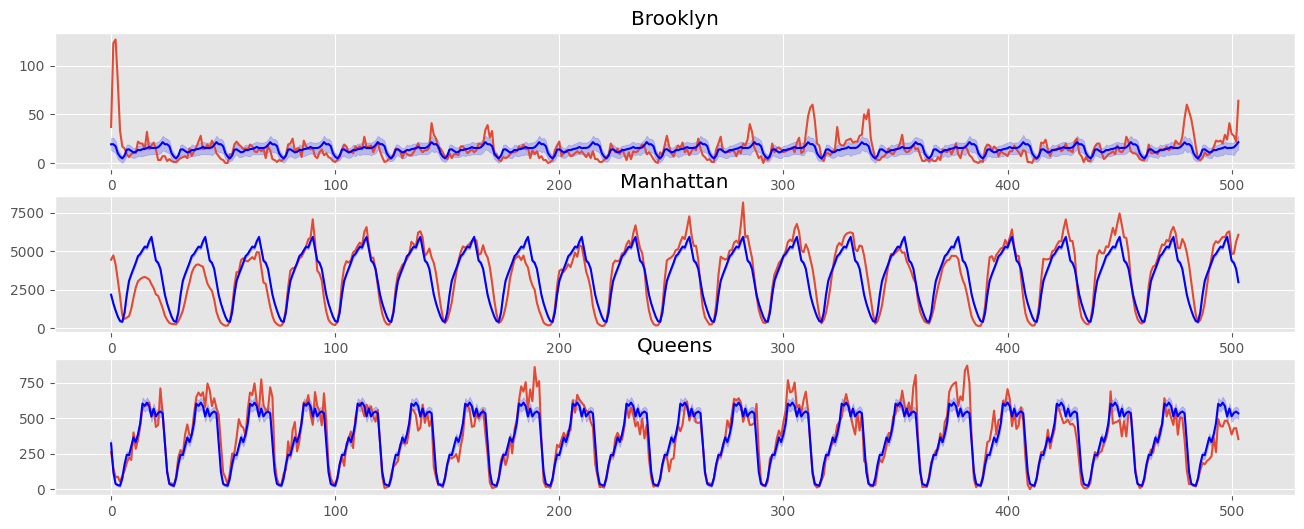

In [47]:
def post_pred_df(df, samples):
    df_predictions = df.copy()
    mean = samples.mean(0)
    hdi = hpdi(samples, 0.89, 0)
    df_predictions['pred'], df_predictions['hdi_low'], df_predictions['hdi_high'] = mean, hdi[0, :], hdi[1, :]
    
    return df_predictions

def plot_posterior(df):
    fig, ax = plt.subplots(3, 1, figsize=(16, 6))

    for borough in df['PU_Borough'].unique():
        city_df = df[df['PU_Borough'] == borough]
        t = np.arange(0, len(city_df))
        ax[borough].plot(t, city_df['num_of_trips'])
        ax[borough].plot(t, city_df['pred'], 'blue')
        ax[borough].fill_between(t, y1=city_df['hdi_low'], y2=city_df['hdi_high'], alpha=.2, color='blue')
        ax[borough].set_title(transformers.named_transformers_['encode_borough'].categories_[0][borough])

predictive = Predictive(model2, mcmc2.get_samples())
predictive_samples = predictive(random.PRNGKey(1), **dlist)['num_of_trips'] #(samples, observation)
df_predictions = post_pred_df(df_train_processed, predictive_samples)
plot_posterior(df_predictions)

So this model has a total of $3\times 24$ parameters, for each borough we have an average effect on each hourm this explains the relation quiet well, i guess adding efect from the day of the week will only increase the fittnes of the model. I wanted to describe the model differently:

$$
numtrips \sim Poisson(\lambda)\\
\lambda = \beta_{[borough]} \times \beta_{[hour]} \\
\beta_{[borough]} \sim Normal(2, 1)\\
\beta_{[hour]} \sim Normal(0, 1)\\
$$
but i think the posteror is too difficult to sample from

### Zero inflated model

https://fehiepsi.github.io/rethinking-numpyro/12-monsters-and-mixtures.html

# Theoretical full model?

In [ ]:
def model1(N_boroughs, borough=None, hour=None, day_of_week=None, num_of_trips=None):
    
    # borogh level model components
    intercept, borough_intercept, bor_sig = (
        numpyro.sample('intercept', dist.Normal(0, 1)), 
        numpyro.sample('borough_intercept', dist.Normal(0, 1).expand([N_boroughs])),
        numpyro.sample('bor_sig', dist.Exponential(1)),
    )
    # target model components
    borough_factor, hour_factor, day_of_week_factor = (
        numpyro.sample('borough_factor', dist.Normal(intercept + borough_intercept[borough], bor_sig)),
        numpyro.sample('hour_factor', dist.Normal(0, 1).expand([24])),
        numpyro.sample('day_of_week_factor', dist.Normal(0, 1).expand([7])),
    )    
    
    # target
    mu, sigma = (
        numpyro.deterministic('mu', borough_factor + hour_factor[hour] + day_of_week_factor[day_of_week]),
        numpyro.sample('sigma', dist.Exponential(1)),
    )

    with numpyro.handlers.reparam(config={'mu': numpyro.infer.reparam.TransformReparam()}):
        


        numpyro.sample('num_of_trips', dist.TransformedDistribution(dist.Normal(0., 1.), dist.transforms.AffineTransform(mu, sigma)), obs=num_of_trips)


def data_model1(df):
    dlist = dict(
        N_boroughs=len(df['PU_Borough'].unique()),
        borough=df['PU_Borough'].values,
        hour=df['hour'].values,
        day_of_week=df['day_of_week'].values,
        num_of_trips=df['num_of_trips'].values,
    )
    return dlist
dlist = data_model1(df_train_processed)


mcmc1 = MCMC(NUTS(model1), num_chains=4, num_warmup=500, num_samples=1000)
mcmc1.run(random.PRNGKey(0), **dlist)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
arviz.summary(mcmc1, var_names=['~mu', '~borough_factor'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bor_sig,0.053,0.012,0.029,0.065,0.006,0.004,6.0,20.0,1.85
borough_intercept[0],-0.357,0.487,-1.274,0.547,0.024,0.017,397.0,761.0,1.02
borough_intercept[1],0.235,0.487,-0.680,1.141,0.025,0.017,397.0,761.0,1.02
borough_intercept[2],-0.014,0.487,-0.930,0.888,0.025,0.017,397.0,756.0,1.02
day_of_week_factor[0],0.521,0.196,0.181,0.858,0.074,0.055,8.0,47.0,1.54
day_of_week_factor[1],0.531,0.197,0.186,0.866,0.074,0.055,8.0,48.0,1.53
day_of_week_factor[2],0.534,0.196,0.200,0.879,0.074,0.055,8.0,52.0,1.54
day_of_week_factor[3],0.542,0.196,0.198,0.876,0.074,0.055,8.0,48.0,1.54
day_of_week_factor[4],0.546,0.196,0.207,0.883,0.074,0.055,8.0,54.0,1.54
day_of_week_factor[5],0.560,0.196,0.217,0.897,0.074,0.055,8.0,50.0,1.54


In [ ]:
dlist

{'N_boroughs': 3,
 'borough': array([0, 1, 2, ..., 0, 1, 2], dtype=int8),
 'hour': array([ 0,  0,  0, ..., 23, 23, 23], dtype=int8),
 'num_of_trips': array([6, 6, 6, ..., 5, 5, 5], dtype=int8)}

In [ ]:
df_train_processed

,PU_Borough,hour,day_of_week,num_of_trips
0,0,0,6,0.403928
1,1,0,6,0.932709
2,2,0,6,0.618748
3,0,1,6,0.535258
4,1,1,6,0.939445
...,...,...,...,...
1507,1,22,5,0.958794
1508,2,22,5,0.673598
1509,0,23,5,0.463536
1510,1,23,5,0.967088
